# Исследовательский анализ данных

- Посмотрим на размер выборки.
- Построим график распределения возраста в выборке.
- Напечатаем на экране 10–15 фотографий и посмотрим, как устроен датасет.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.sample(5) # посмотрим выборку из датасета

,file_name,real_age
3397,003397.jpg,19
5924,005925.jpg,18
859,000859.jpg,41
6350,006354.jpg,32
3806,003806.jpg,23


In [4]:
labels.info() # посмотрим кол-во строк, а заодно наличие пропусков

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.describe() # посмотрим, нет ли явных аномалий в значениях возрастов

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
labels.duplicated().sum() # проверим наличие явных дубликатов

0

In [7]:
# яркость цветов в пикселях приводим к диапазону от 0 до 1, фото будем подавать в будущую модель
# батчами по 32шт и размером 224 на 224 пикселя

datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


**Промежуточный вывод:** В таблице 7591 уникальных наименований файлов и соответствующее кол-во строк с указанием возраста (от 1 до 100 лет), пропусков нет, явных аномалий в значениях возраста нет, количество фото в папке соответствует кол-ву строк в таблице.

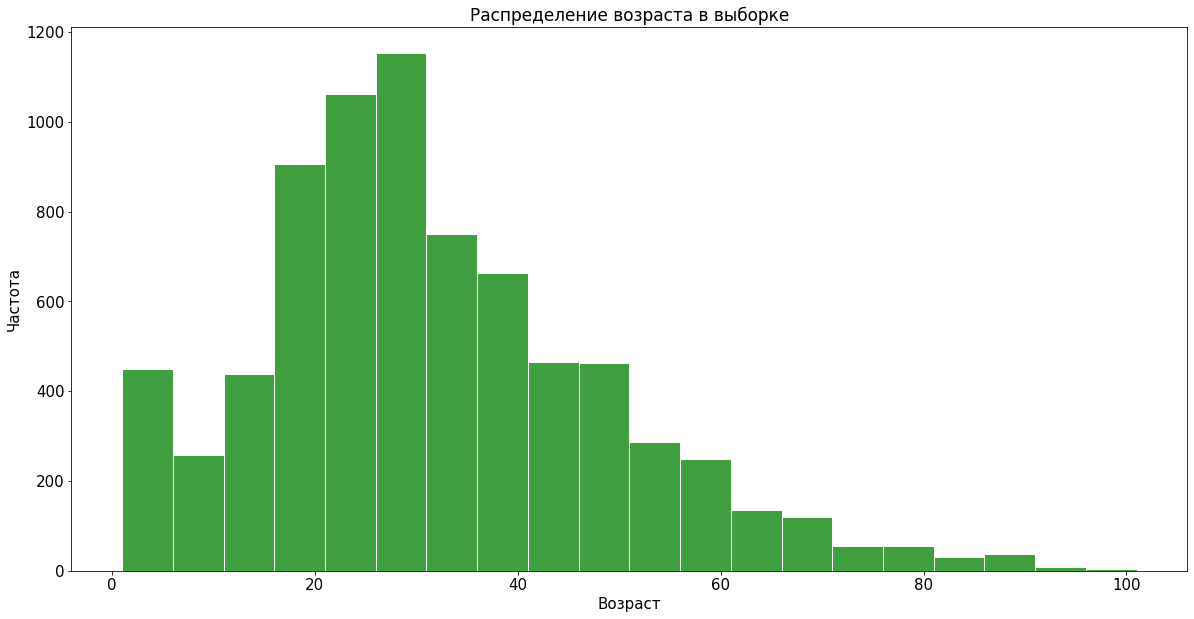

In [10]:
plt.figure(figsize=(20, 10)) # рассмотрим распределение возраста
ax = sns.histplot(data=labels, x='real_age', binwidth=5, color='green', edgecolor='white')
ax.set_title('Распределение возраста в выборке', fontsize=17)
ax.set_xlabel('Возраст',fontsize=15)
ax.set_ylabel('Частота',fontsize=15)
ax.tick_params(labelsize=15);

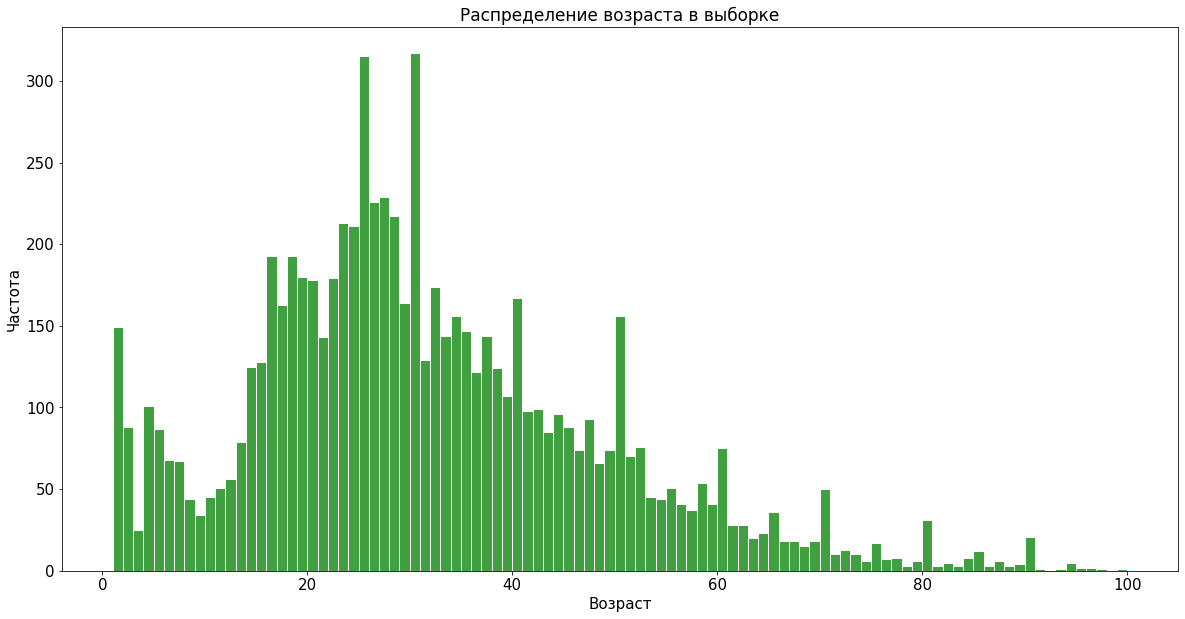

In [8]:
plt.figure(figsize=(20, 10)) # рассмотрим распределение возраста
ax = sns.histplot(data=labels, x='real_age', binwidth=1, color='green', edgecolor='white')
ax.set_title('Распределение возраста в выборке', fontsize=17)
ax.set_xlabel('Возраст',fontsize=15)
ax.set_ylabel('Частота',fontsize=15)
ax.tick_params(labelsize=15);

**Промежуточный вывод:** Больше всего данных для обучения в диапазоне возрастов примерно от 15 до 40 лет, самые большие пики в районе 25 и 30 лет. По возрастам свыше 60 лет (а особенно свыше 70 и тем более 80) данных, конечно, маловато, но посмотрим на результаты модели при обучении на датасете.  

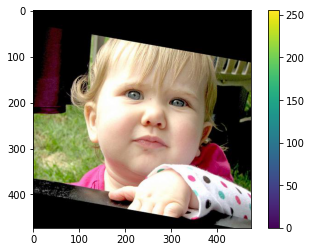

In [8]:
# возьмем для примера фото годовалого человека из полученной выше выборки

image = Image.open('/datasets/faces/final_files/004339.jpg')
array = np.array(image)

plt.imshow(array)
plt.colorbar();

In [10]:
# посмотрим реальный размер изображения (у других фото, естественно, могут быть другие размеры)

array.shape

(473, 474, 3)

**Промежуточный вывод:** Цветные изображения RGB (3 слоя пикселей), фото, выбранное для примера имеет размерность 473 на 474 пикселя. Для унификации все фото будут подаваться в модель в размере 224 на 224 пикселя бытчами по 32 шт. и также с 3 слоями RGB, убедимся ниже, что фичи предобрабатываются корректно.

In [11]:
# перепроверим параметры изображений в батчах, которые будут передаваться будущей модели

features, target = next(datagen_flow) # изменил название переменной на datagen_flow после ком ментария ревьюера
print(features.shape)

(32, 224, 224, 3)


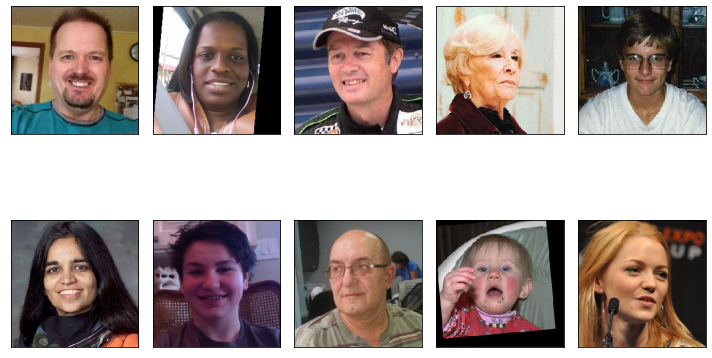

In [12]:
# напечатаем 10 фото для ознакомления

fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод:** Размеры цветных (RGB) фото унифицированы до 224 на 224 пикселя для подачи в модель батчами по 32шт. Можно приступать к обучению.

Что касается самих фото, то даже 10 напечатанных фото демонстрируют отсутствие единого стандарта: часть лиц обращена ровно в камеру, другие могут быть повернуты вбок, вплоть до 45 градусов (примерно), могут быть наклонены, кто-то может улыбаться, кто-то застыл на полуслове или даже крике, в кадре с лицом могут присутствовать посторонние предметы (микрофон, например), рука может закрывать часть лица, могут быть наушники, головные уборы, очки. Уровень освещенности лица в кадре, качество детализации и степень приближения могут ощутимо различаться от кадра к кадру, фон может быть очень разным, со своими резкими контурами или делающий контур лица не так резко выделяющимся. С одной стороны это не должно облегчить процесс обучения, но с другой должно лучше подготовить модель к тому, что в реальной ситуации получения кадров с камеры в магазине изображение тоже не всегда будет идеальным. Фото для датасета, вероятно, не делались специально по одному лекалу, так как это трудо- и ресурсо-затратно, возможно (как один из вариантов или один из источников), они подбирались из открытых источников в интернете, в таком случае, точный возраст составители могли не знать в каждой ситуации и примерно относить к ближайшей возрастной категории, что могло бы объяснить пики у "круглых" значений возраста в распределении выборки. 

# Обучение модели

```python
import pandas as pd
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255) #horizontal_flip=True,
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return test_gen_flow

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5, 
                steps_per_epoch=None, validation_steps=None):

    train_gen_flow = train_data
    test_gen_flow = test_data
    
    model.fit(train_gen_flow, 
              validation_data=test_gen_flow,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    
    return model
```

# Анализ результатов

Приятно радует, что использовав пониженное значение шага learning rate (lr=0.0001) для алгоритма Adam, веса от ResNet50, предобученной на датасете Imagenet с 1000 классов, активацию ReLU в последнем слое (отвечающем за предсказание) и MSE вместо MAE в качестве функции потерь, удалось всего за 5 эпох и без применения аугментации получить значение метрики MAE на тестовой выборки даже не ниже максимальных пороговых 8, а ниже 7, что отмечено в задаче, как более приятный результат. Обучение заняло немного времени и возможно при увеличении кол-ва эпох и добавлении аугментации удалось бы добиться дополнительного улучшения целевой метрики, но ценой увеличения времени обучения, затраченных ресурсов. Также стоит отметить, что, несмотря на уменьшение целевой метрики на тестовой выборки от эпохи к эпохе, модель переобучилась, что, вроде как, явление не редкое для подобных сетей.